In [2]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [141]:
train_Y = np.log1p(Train_data['total_price'])
ids = Test_data['building_id']

tp = copy.deepcopy(np.log1p(Train_data['total_price']))

Train_data = Train_data.drop(['building_id', 'total_price'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

df = pd.concat([Train_data,Test_data])


df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,NaN,NaN,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,NaN,NaN,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,NaN,NaN,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,NaN,81138.889762,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,NaN,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


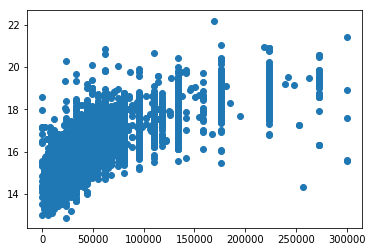

In [142]:
df.loc[:, "parking_price"] = df["parking_price"].clip(0.1, 300000)

train_num = train_Y.shape[0]
train_X = df[:train_num]

plt.scatter(train_X["parking_price"], train_Y)

In [143]:
park_not_null = df[df['parking_price'].notnull()]
park_is_null = df[df['parking_price'].isnull()].drop(['parking_price'] , axis=1)
park_is_null = park_is_null.drop(['parking_area'] , axis=1)
park_is_null = park_is_null.fillna(park_is_null.mean())

park_X = park_not_null.drop(['parking_price'] , axis=1)
park_Y = park_not_null['parking_price']

park_X = park_X.drop(['parking_area'] , axis=1)
park_X = park_X.fillna(park_X.mean())

In [144]:
RFR = RandomForestRegressor()
RFR.fit(park_X, park_Y)

park_pred = RFR.predict(park_is_null)
df.loc[df['parking_price'].isnull(), 'parking_price'] = np.log1p(park_pred)

In [146]:
df = df.drop(['parking_area'] , axis=1)
df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_price,txn_floor,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,8.413985,3.0,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,10.428083,5.0,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,10.474860,1.0,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,81138.889762,13.0,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,8.673699,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [147]:
df = df.fillna(df.mean())
df["total_building_area"] = df["building_area"] * df["total_floor"]
df["total_income"] = df["village_income_median"] * df["town_population"]
df["area_percent"] = df["land_area"] / df["town_area"]

df = pd.get_dummies(data = df, columns = ["city"])
df = pd.get_dummies(data = df, columns = ["building_type"])

train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

In [148]:
train_X.head()

,building_material,txn_dt,total_floor,building_use,building_complete_dt,parking_way,parking_price,txn_floor,land_area,building_area,...,city_12,city_13,city_14,city_17,city_21,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4
0,8,18674,4,2,6271,2,8.413985,3.000000,18.144460,3.418175,...,0,0,0,0,1,0,0,0,1,0
1,8,18800,5,2,7885,2,10.428083,5.000000,11.387227,4.041309,...,0,0,0,0,0,0,1,0,0,0
2,8,19289,4,2,6028,2,10.474860,1.000000,21.426802,5.584279,...,0,0,0,0,0,0,1,0,0,0
3,8,20385,24,2,18325,0,81138.889762,13.000000,11.387227,13.563031,...,0,0,0,0,1,1,0,0,0,0
4,1,20657,2,2,6880,2,8.673699,5.393906,61.306524,4.688108,...,0,0,0,0,1,0,0,0,0,1


In [149]:
estimator = RandomForestRegressor()
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

building_area            4.876382e-01
XIII_10000               2.359475e-01
building_complete_dt     2.365308e-02
parking_price            2.289746e-02
land_area                1.783439e-02
jobschool_rate           1.751149e-02
XIII_5000                1.173320e-02
txn_dt                   1.068842e-02
V_10000                  1.027195e-02
village_income_median    7.652819e-03
junior_rate              6.381612e-03
divorce_rate             6.223637e-03
VII_1000                 4.930949e-03
highschool_rate          4.897097e-03
V_5000                   3.967039e-03
building_type_4          3.952702e-03
total_building_area      3.901101e-03
bachelor_rate            3.834862e-03
master_rate              3.817159e-03
area_percent             3.805092e-03
txn_floor                3.487224e-03
elementary_rate          3.330305e-03
VII_10000                2.965048e-03
total_income             2.771725e-03
building_type_1          2.618851e-03
II_1000                  2.606397e-03
lon         

In [152]:
high_feature = list(feats[:50].index)

train_X = df[:train_num][high_feature]
test_X = df[train_num:][high_feature]

#MM = MinMaxScaler()
#train_X = MM.fit_transform(train_X)
#test_X = MM.fit_transform(test_X)

In [153]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=4)

estimator_ = RandomForestRegressor()
estimator_.fit(x_train, y_train)

print(cross_val_score(estimator_, x_train, y_train, cv=5).mean())

y_pred = estimator_.predict(x_test)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))

0.9423899158152566
Mean squared error: 0.0690


In [154]:
predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price#.astype(np.int32)
submit.to_csv("2019-06-03.csv",index=False)